In [3]:
import numpy as np
from polara.recommender.data import RecommenderData
from polara.recommender.models import RecommenderModel
from polara.tools.movielens import get_movielens_data

# Get Movielens-1M data

this will download movielens-1m dataset from http://grouplens.org/datasets/movielens/:

In [4]:
data, genres = get_movielens_data(get_genres=True)

In [5]:
data.head()

,userid,movieid,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000209 entries, 0 to 1000208
Data columns (total 3 columns):
userid     1000209 non-null int64
movieid    1000209 non-null int64
rating     1000209 non-null int64
dtypes: int64(3)
memory usage: 22.9 MB


In [7]:
genres.head()

,movieid,movienm,genreid
0,1,Toy Story (1995),Animation
1,1,Toy Story (1995),Children's
2,1,Toy Story (1995),Comedy
3,2,Jumanji (1995),Adventure
4,2,Jumanji (1995),Children's


In [8]:
%matplotlib inline

Rating distribution in the dataset:

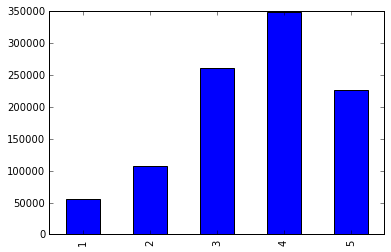

In [9]:
data.rating.value_counts().sort_index().plot.bar()

# Building our first recommender model

## Preparing data

`RecommenderData` class provides a set of tools for manipulating the data and preparing it for experimentation.

The syntax is:

`RecommenderData(data, userid=<user column name>, itemid=<items column name>, feedback=<rating or other type of feedback>)`

In [10]:
data_model = RecommenderData(data, 'userid', 'movieid', 'rating')

It has a number of parameters to control how the data is processed. Defaults are fine to start with:

In [11]:
data_model.get_configuration()

{'holdout_size': 3,
 'negative_prediction': False,
 'permute_tops': False,
 'random_holdout': False,
 'shuffle_data': False,
 'test_fold': 5,
 'test_ratio': 0.2,
 'test_sample': None}

Use `prepare` method to split the dataset into 2 parts: training data and test data.

In [12]:
data_model.prepare()

Preparing data
27 unseen items filtered from testset.


The dataset is split according to `test_fold` and `test_ratio` attributes. By default it uses first 80% of users for training and last 20% of the users as test data.

In [13]:
data_model.training.head()

,userid,movieid,rating
0,0,1099,5
1,0,634,3
2,0,848,3
3,0,3161,4
4,0,2153,5


In [14]:
data_model.training.shape

(807458, 3)

The test data is further split into `testset` and evaluation set (`evalset`). Testset is used to generate recommendations, which are than evaluated against the evaluation set.

In [15]:
data_model.test.testset.head()

,userid,movieid,rating
807459,0,577,4
807517,0,2153,5
807516,0,1290,4
807515,0,1283,4
807514,0,1270,3


In [16]:
data_model.test.testset.shape

(189100, 3)

In [17]:
data_model.test.evalset.head()

,userid,movieid,rating
807458,0,575,5
807460,0,1881,5
807464,0,846,5
807546,1,1878,5
807549,1,576,5


In [18]:
data_model.test.evalset.shape

(3624, 3)

The users in the test and evaluation sets are the same (but this users are not in the `training` set!).
For every test user the evaluation set contains a fixed number of items which are held out from the original test data. The number of holdout items is controlled by `holdout_size` parameter. By default it's set to 3:

In [19]:
data_model.holdout_size

3

In [20]:
data_model.test.evalset.groupby('userid').movieid.count().head()

userid
0    3
1    3
2    3
3    3
4    3
Name: movieid, dtype: int64

## Creating recommender model

You can create your own model by subclassing `RecommenderModel` class and defining two required methods:  `self.build()`  and  `self.get_recommendations()`:

In [21]:
class TopMovies(RecommenderModel):
    def build(self):
        self._recommendations = None # this is required line in order to ensure consitency in experiments
        itemid = self.data.fields.itemid # get the name of the column, that corresponds to movieid
        
        # calculate popularity of the movies based on the number of ratings
        item_scores = self.data.training[itemid].value_counts().sort_index().values
        
        # store it for later use in some attribute
        self.item_scores = item_scores
        
        
    def get_recommendations(self):
        userid = self.data.fields.userid #get the name of the column, that corresponds to userid
        
        # get the number of test users
        # we expect that userid doesn't have gaps in numbering (as it might be in original dataset
        # RecommenderData class takes care of that
        num_users = self.data.test.testset[userid].max() + 1
        
        # repeat computed popularity scores in accordance with the number of test users
        scores = np.repeat(self.item_scores[None, :], num_users, axis=0)
        
        # we got the scores, but what we actually need is items (their id)
        # we also need only top-k items, not all of them (for top-k recommendation task)
        # here's how to get it:
        top_recs = self.get_topk_items(scores)
        # here leftmost items are those with the highest scores
        
        return top_recs

Note, that recommendations, generated by this model, do not take into account the fact, that some of the recommended items may be present in the test set and thus, should not be recommended (they are considered seen by a test user). In order to fix that you can use `filter_seen` parameter along with `downvote_seen_items` method as follows:

```
if self.filter_seen:
    #prevent seen items from appearing in recommendations
    itemid = self.data.fields.itemid
    test_idx = (test_data[userid].values.astype(np.int64),
                test_data[itemid].values.astype(np.int64))
    self.downvote_seen_items(scores, test_idx)
```
With this procedure "seen" items will get the lowest scores and they will be sorted out. Place this code snippet inside the `get_recommendations` routine before handovering scores into `get_top_k_items`. This will improve the baseline.

### Alternative way

Another way is to define `slice_recommendations` instead of `get_recommendations` method. With `slice_recommendations` defined, the model will scale better when huge datasets are used.

The method `slice_recommendations` takes a piece of the test data slice by slice instead of processing it as a whole. Slice if defined by `start` and `stop` parameter (which are simply a userid to start with and userid to stop at). Slicing the data avoids memory overhead and leads to a faster evaluation of models. Slicing is done automatically behind the scene and you don't have to specify anything else. Another advantage: seen items will be automatically sorted out from recommendations as long as `filter_seen` attribute is set to `True` (it is by default). So it will requires less line of code.

In [ ]:
 class TopMoviesALT(RecommenderModel):
    def build(self):
        # should be the same as in TopMovies
        
    def slice_recommendations(self, test_data, shape, start, stop):
        # current implementation requires handovering slice data in specific format further,
        # and the easiest way to get it is via get_test_matrix method. It also returns
        # test data in sparse matrix format, but as our recommender model is non-personalized
        # we don't actually need it. See SVDModel implementation to see when it's useful.
        test_matrix, slice_data = self.get_test_matrix(test_data, shape, (start, stop))
        nusers = stop - start
        scores = np.repeat(self.item_scores[None, :], nusers, axis=0)
        return scores, slice_data

Now everything is set to create an instance of the recommender model and produce recommendations.

### generating recommendations:

In [20]:
top = TopMovies(data_model) # the model takes as input parameter the recommender data model

In [21]:
top.build()

In [22]:
recs = top.get_recommendations()

In [23]:
recs

array([[2638,  252, 1101, ..., 2363,  575, 1443],
       [2638,  252, 1101, ..., 2363,  575, 1443],
       [2638,  252, 1101, ..., 2363,  575, 1443],
       ..., 
       [2638,  252, 1101, ..., 2363,  575, 1443],
       [2638,  252, 1101, ..., 2363,  575, 1443],
       [2638,  252, 1101, ..., 2363,  575, 1443]], dtype=int64)

In [24]:
recs.shape

(1208L, 10L)

In [25]:
top.topk

10

You can evaluate your model befotre submitting the results (to ensure that you have improved above baseline):

In [26]:
top.evaluate()

Hits(true_positive=548, true_negative=0, false_positive=0, false_negative=3076)

Try to change your model to maximize the `true_positive` score.

### submitting your model:

After you have created your perfect recsys model, firstly, save your recommendation into file. Please, use your name as the name for file (this will be used to display at leaderboard)

In [27]:
np.savez('your_full_name', recs=recs)

Now you can uppload your results:

In [28]:
import requests

files = {'upload': open('your_full_name.npz','rb')}
url = "http://isp2017.azurewebsites.net/upload"

r = requests.post(url, files=files)

Verify, that upload is successful:

In [29]:
print r.status_code, r.reason

200 OK


You can also do it manyally at http://isp2017.azurewebsites.net/upload

Check out how do your result compare to others at: http://isp2017.azurewebsites.net